*Author: [Daniel Puente Viejo](https://www.linkedin.com/in/danielpuenteviejo/)*

## **LangGraph + Mistral: CV Evaluator** 

<img src="imgs/tutorial_gif.gif">   

In this tutorial, we will show how to use the LangGraph and Mistral to create a simple CV evaluator. 

### **Index:**

- <a href='#1'><ins>1 - Libraries</ins></a>
- <a href='#2'><ins>2 - MistralAI</ins></a>
    - <a href='#2.1'><ins>2.1 - MistralAI Configuration</ins></a>
    - <a href='#2.2'><ins>2.2 - MistralAI Example</ins></a>
- <a href='#3'><ins>3 - LangGraph CV Evaluation</ins></a>
    - <a href='#3.1'><ins>3.1 - State Definition</ins></a>
    - <a href='#3.2'><ins>3.2 - Agents</ins></a>
        - <a href='#3.2.1'><ins>3.2.1 - Agent 1: Read CV</ins></a>
        - <a href='#3.2.2'><ins>3.2.2 - Agent 2: Read Job Description</ins></a>
        - <a href='#3.2.3'><ins>3.2.3 - Agent 3: Evaluate CV</ins></a>
        - <a href='#3.2.4'><ins>3.2.4 - Agent 4: Draft Email</ins></a>
    - <a href='#3.3'><ins>3.3 - Graph Construction</ins></a>
    - <a href='#3.4'><ins>3.4 - Execution</ins></a>

### <a id='1' style="color: skyblue;">**1 - Libraries**</a>

In [1]:
from langchain_core.messages import SystemMessage, ToolMessage, AIMessage, HumanMessage
from langchain_mistralai import ChatMistralAI
from langgraph.graph import StateGraph, START, END

from typing_extensions import TypedDict
import os
import uuid
from typing import Dict

from dotenv import load_dotenv
load_dotenv()

True

### <a id='2' style="color: skyblue;">**2 - MistralAI**</a>

Mistral will serve as the LLM engine for this guide. To begin, it's essential to understand how to set it up and use it effectively. Start by logging in to the Mistral platform and generating an API key. You can do this by visiting the following link → https://console.mistral.ai/api-keys/

After logging in, you'll see a screen similar to the one below. Click on "Create new key," assign a name to your key, and it will be ready for use.
Now that you have your API key, you can integrate Mistral with LangChain to fully utilize its capabilities. To do so, you'll need to import the LangChain Mistral library, configure it with your API key, and specify the desired model and parameters.

#### <a id='2.1' style="color: azure;">**2.1 - MistralAI Configuration**</a>

In [2]:
# Configure Mistral API Key
os.environ['MISTRAL_API_KEY'] = os.getenv('MISTRAL_API_KEY') # Something similar to: "8ghJa1TYpX3QaVfvkLtmNz6evxMPrtOF"

# LLM Configuration
model = "mistral-small-latest"
llm = ChatMistralAI(
    model=model,
    temperature=0,
    max_retries=5
)

#### <a id='2.2' style="color: azure;">**2.2 - MistralAI Example**</a>

In [3]:
# Prompts
sys_prompt = "You are a helpful assistant that translates English to Spanish"
hum_prompt = "Translate the user sentence without giving more details just the translation: I love programming."

# Invoke LLM
response = llm.invoke([
    SystemMessage(content=sys_prompt),
    HumanMessage(content=hum_prompt)]
).content.strip()

print(response)

Me encanta programar.


### <a id='3' style="color: skyblue;">**3 - Langraph CV Evaluation**</a>  

In this section, we will use the LangGraph to create a simple CV evaluator. We will use the MistralAI as the LLM engine.

#### <a id='3.1' style="color: azure;">**3.1 - State Definition**</a>  

The first step is to define the State. The State establishes how messages are passed between agents. This structure ensures that information flows seamlessly throughout the system. Typing is crucial here, as it helps maintain clarity and consistency. In this case, we use dictionaries for their simplicity and ease of tracking.

In [4]:
# State definition
class State(TypedDict):
    messages: Dict

We start by defining a simple function to read `.txt` files:

In [5]:
# Define functions for processing
def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

Before diving into the code, it's important to establish the initial state (start_state) that comes into play. The start_state is defined as follows:

In [6]:
cv_path = "data/cv.txt"
job_path = "data/job_description.txt"
start_state = {"messages": {"cv_path": cv_path, "job_path": job_path}}

#### <a id='3.2' style="color: azure;">**3.2 - Agents**</a>

##### <a id='3.2.1' style="color: azure;">**3.2.1 - Agent 1: Read CV**</a>

The first function, `get_cv_content`, takes the `start_state` as input to begin the process. This function extracts the CV file path from the initial state, reads the file content, and updates the state with the CV content while retaining the job file path. The updated state is then passed to the next agent.   

The `ToolMessage` is a standardized way to pass messages from agent to agent, using an ID, `tool_call_id`, to keep track of each message sent.

In [7]:
# Read CV
def get_cv_content(state: dict): # The state here is -> {"messages": {"cv_path": cv_path, "job_path": job_path}}
    print("***** get_cv_content *****")

    # Extract the CV file path from the state
    cv_path = state['messages']['cv_path']
    cv_content = read_file(cv_path)

    # Create a ToolMessage object with the CV content and a unique tool call ID
    tool_call = ToolMessage(
        content=cv_content,
        tool_call_id=str(uuid.uuid4())
    )

    # Update the state with the CV content and retain the job file path
    new_state = {
        "messages": {
            "job_path": state['messages']['job_path'],
            "cv_content": tool_call
        }
    }
    return new_state

#### <a id='3.2.2' style="color: azure;">**3.2.2 - Agent 2: Read Job Description**</a>

The order of the agents will be indicated once all agents and their tools are fully defined. However, as we have progressed, we know that after reading the CV, the logical next step is to process the job description. This sequence is essential because the updated state from `get_cv_content` provides the `cv_content` and retains the `job_path`, which the next agent, `get_job_description`, needs to accomplish its goal.   

The `get_job_description` function follows a similar structure. It extracts the job description file path, reads the file content, creates a standardized message, and updates the state with both the CV and job description content for the next agent.

In [8]:
# Read Job Offer
def get_job_description(state: dict): # The state here will be the get_cv_content result -> {"messages": {"job_path": job_path, "cv_content": ___}}
    print("***** get_job_description *****")

    # Extract the job description file path from the state
    job_path = state['messages']['job_path']

    # Read the content of the job description file
    job_content = read_file(job_path)

    # Create a ToolMessage object with the job description content and a unique tool call ID
    tool_call = ToolMessage(
        content=job_content,
        tool_call_id=str(uuid.uuid4())
    )

    # Update the state with the job description content and retain the CV content
    new_state = {
        "messages": {
            "cv_content": state['messages']['cv_content'],
            "job_content": tool_call
        }
    }
    return new_state

##### <a id='3.2.3' style="color: azure;">**3.2.3 - Agent 3: Evaluate CV**</a> 

The `evaluate_match` function takes the state returned by the `get_job_description` agent and applies its own logic. The process is straightforward: it extracts the content of the CV and the job description from the state, constructs a detailed prompt, and uses it to evaluate the potential fit of the candidate for the job.  

The logic involves two types of prompts: a system prompt that defines the evaluation task, and a human prompt that includes the content of the CV and job description, guiding the evaluation in a professional and detailed manner. The combined prompts are then passed to the LLM for evaluation.  

Once the LLM generates a response, the result is wrapped in an `AIMessage`, which serves as a standardized way to pass AI-generated responses to the next agent. The `AIMessage` functions similarly to the `ToolMessage`, but it explicitly indicates that the content has been created by the AI.

In [9]:
# Evaluate Match
def evaluate_match(state: dict): # The state here will be the get_job_description result -> {"messages": {"cv_content": ___, "job_content": ___}}
    print("***** evaluate_match *****")

    # Extract the CV and job description content from the state
    cv_content = state["messages"]["cv_content"].content
    job_content = state["messages"]["job_content"].content

    # Create the evaluation prompts
    hum_evaluation_template = """CV:
    {cv}
    ===
    Job Description:
    {job}
    ===
    Evaluate whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific reasons for your assessment, ensuring a detailed and professional response:
    """
    hum_evaluation_prompt = hum_evaluation_template.format(cv=cv_content, job=job_content)
    sys_evaluation_prompt = """You are tasked with evaluating whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific, detailed reasons for your assessment."""

    # Invoke the LLM with the evaluation prompts
    response = llm.invoke([SystemMessage(content=sys_evaluation_prompt),
                           HumanMessage(content=hum_evaluation_prompt)])
    content = response.content.strip()

    # Create an AIMessage object with the evaluation response and a unique AI call ID
    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    # Update the state with the evaluation response
    new_state = {
        "messages": {
            "evaluation": ai_call
        }
    }
    return new_state

##### <a id='3.2.4' style="color: azure;">**3.2.4 - Agent 4: Draft Email**</a>

The `generate_email` agent is the final step in the workflow and follows a similar structure to the evaluate_match agent. Its purpose is to take the evaluation result produced by the previous agent, craft a well-structured prompt, and generate a draft email communicating the selection decision to the candidate.

In [10]:
# Generate Email
def generate_email(state: dict): # The state here will be the evaluate_match result -> {"messages": {"evaluation": ___}}
    print("***** generate_email *****")

    # Extract the evaluation result from the state
    evaluation_result = state["messages"]["evaluation"].content

    # Create the email prompts
    hum_email_template = """Job Application Evaluation:
    {evaluation}
    ===
    Based on the evaluation of the match between the candidate's CV and the job description, draft an email to the candidate communicating the result of the assessment. Clearly indicate whether or not the candidate has been selected for the position and provide the reasons for the decision. Ensure the tone is polite, professional, and respectful, starting the email with a courteous acknowledgment.
    Email:
    """
    hum_email_prompt = hum_email_template.format(evaluation=evaluation_result)
    sys_email_prompt = """You are a hiring manager tasked with drafting an email to a candidate regarding the result of their job application assessment. Clearly communicate whether the candidate has been selected for the position, and provide reasons for the decision. Maintain a polite, professional, and respectful tone, starting the email with a courteous acknowledgment."""

    # Invoke the LLM with the email prompts
    response = llm.invoke([SystemMessage(content=sys_email_prompt),
                           HumanMessage(content=hum_email_prompt)])
    content = response.content.strip()

    # Create an AIMessage object with the email content and a unique AI call ID
    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    # Update the state with the email content
    new_state = {
        "messages": {
            "email": ai_call
        }
    }

    return new_state

#### <a id='3.3' style="color: azure;">**3.3 - Graph Construction**</a>

Once all the agents are defined, we move on to constructing the graph. This step involves specifying each node in the workflow, defining the connections between the nodes, and creating a visual representation of the process.   

To complete the workflow, we construct a StateGraph based on the State class we defined at the beginning. For the nodes, we simply add the functions we have defined, assigning each function a name to represent its corresponding agent. For the edges, we specify the connections between the agents. The first argument indicates the current agent, while the second argument points to the next one in the sequence. Finally, we compile the graph and visualize it

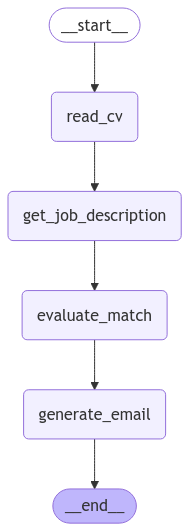

In [11]:
# Start the Graph with the initial state
workflow = StateGraph(State)

# We add the nodes that corresponds to the functions we defined. We have to give them a name
workflow.add_node("read_cv", get_cv_content)
workflow.add_node("get_job_description", get_job_description)
workflow.add_node("evaluate_match", evaluate_match)
workflow.add_node("generate_email", generate_email)

# We add the edges that connect the nodes.
## We start from the START and indicate the next node, that in this case is "read_cv"
workflow.add_edge(START, "read_cv")
workflow.add_edge("read_cv", "get_job_description")
workflow.add_edge("get_job_description", "evaluate_match")
workflow.add_edge("evaluate_match", "generate_email")
workflow.add_edge("generate_email", END)

# We compile the graph
graph = workflow.compile()

# We can visualize the graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

#### <a id='3.4' style="color: azure;">**3.4 - Execution**</a>

Now we just need to run the graph starting with the start that we have already defined:

In [12]:
# Iterate over the graph
for output in graph.stream(start_state):
    print("Current Output:", output)

print("\n***** Process completed successfully!! *****\n")
print(output['generate_email']['messages']['email'].content)

***** get_cv_content *****
Current Output: {'read_cv': {'messages': {'job_path': 'data/job_description.txt', 'cv_content': ToolMessage(content="Daniel Puente Viejo\n+34 638 097 547\ndaniel.puenteviejo@gmail.com\nhttps://github.com/DanielPuentee | https://www.linkedin.com/in/danielpuenteviejo | https://medium.com/@daniel.puenteviejo | https://huggingface.co/D0k-tor\n\n---\n\nPROFESSIONAL EXPERIENCE\n\nNTT Data\n➢ Clients: Cepsa, Repsol, Unsere Grüne Glasfaser, RED.es, BBVA, NTT Data (Intern client)\n\nExternal Senior AI Engineer at Repsol; Bilbao, Spain\n*10/2024 - Present*\n- Led the design of Repsol's cross AI Multi-Agent platform and LLMOps platform, including LLM API Management, to support scalable generative AI applications (Azure-oriented solutions).\n- Designed and managed the technical design of multiple Gen AI MVPs, driving innovation in all business areas.\n\nGenerative AI II Engineer; Bilbao, Spain\n*05/2024 - 10/2024*\n- Developer of a Generative AI platform on AWS, valued a